In [51]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [26]:
# link to data here

In [27]:
max_squence_length = 100
max_vocab_size = 20000
embedding_dim = 50

In [28]:
word2vec_file_path = 'data/glove.6B.50d.txt'
toxic_file_path = 'data/train.csv'
toxic_test_file_path = 'data/test.csv'

In [29]:
def get_word2vec(file_name):
    word2vec = {}
    with open(file_name, 'r') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vec = np.array(values[1:], dtype=np.float32)
            word2vec[word] = vec
    return word2vec

In [30]:
def get_toxic_data(file_name):
    train = pd.read_csv(file_name)
    sentences = train["comment_text"].fillna("DUMMY_VALUE").values
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    targets = train[labels].values
    return sentences, labels, targets
    

In [31]:
word2vec = get_word2vec(word2vec_file_path)
sentences, labels, targets = get_toxic_data(toxic_file_path)

In [32]:
print('# of words: ', len(word2vec))

# of words:  400000


In [33]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# note the index starts from 1 instead of 0
word2index = tokenizer.word_index

In [34]:
print(len(word2index))

210337


In [35]:
num_vocab = min(len(word2index) + 1, max_vocab_size)

embedding_matrix = np.zeros((num_vocab, embedding_dim))
for word, index in word2index.items():
    if index < max_vocab_size:
        vec = word2vec.get(word)
        if vec is not None:
            embedding_matrix[index] = vec

print(embedding_matrix.shape)

(20000, 50)


In [36]:
data = pad_sequences(sequences, maxlen=max_squence_length)
print(data.shape)

(159571, 100)


In [37]:
type(data)
train_data = data[:140000]
test_data = data[140000:]
train_targets = targets[:140000]
test_targets = targets[140000:]
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(140000, 100)
(19571, 100)
(140000, 6)
(19571, 6)


## CNN Model

In [38]:
embedding_layer = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=max_squence_length,
    trainable=False)

In [41]:
input_ = Input(shape=(max_squence_length, ))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = Dropout(0.5)(x)
x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(labels), activation='sigmoid')(x)

model = Model(input_, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 128)           19328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
__________

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
validation_split = 0.2
batch_size = 512
epochs = 10

r = model.fit(train_data, train_targets, batch_size=batch_size, epochs = epochs, validation_split=validation_split)

Train on 112000 samples, validate on 28000 samples
Epoch 1/10
112000/112000 [==============================] - 646s - loss: 0.0665 - acc: 0.9771 - val_loss: 0.0622 - val_acc: 0.9778
Epoch 2/10
112000/112000 [==============================] - 715s - loss: 0.0641 - acc: 0.9776 - val_loss: 0.0611 - val_acc: 0.9782
Epoch 3/10
112000/112000 [==============================] - 708s - loss: 0.0629 - acc: 0.9781 - val_loss: 0.0598 - val_acc: 0.9787
Epoch 4/10
112000/112000 [==============================] - 712s - loss: 0.0623 - acc: 0.9781 - val_loss: 0.0595 - val_acc: 0.9789
Epoch 5/10
112000/112000 [==============================] - 751s - loss: 0.0613 - acc: 0.9785 - val_loss: 0.0587 - val_acc: 0.9795
Epoch 6/10
112000/112000 [==============================] - 676s - loss: 0.0605 - acc: 0.9785 - val_loss: 0.0578 - val_acc: 0.9794
Epoch 7/10
112000/112000 [==============================] - 637s - loss: 0.0600 - acc: 0.9788 - val_loss: 0.0582 - val_acc: 0.9789
Epoch 8/10
112000/112000 [======

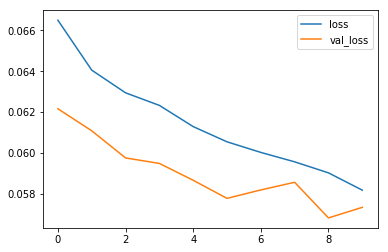

In [61]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

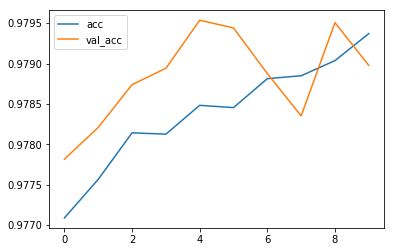

In [62]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [46]:
p = model.predict(test_data)

In [47]:
aucs = []
for j in range(6):
    auc = roc_auc_score(test_targets[:, j], p[:, j])
    aucs.append(auc)

In [48]:
print(np.mean(aucs))

0.960624188092


## RNN Model

In [66]:
input_ = Input(shape=(max_squence_length, ))
x = embedding_layer(input_)
x = Bidirectional(LSTM(64, dropout=0.5))(x)
output = Dense(len(labels), activation='sigmoid')(x)
model = Model(input_, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 1,059,654
Trainable params: 59,654
Non-trainable params: 1,000,000
_________________________________________________________________


In [67]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
validation_split = 0.2
batch_size = 512
epochs = 5

r = model.fit(train_data, train_targets, batch_size=batch_size, epochs = epochs, validation_split=validation_split)

Train on 112000 samples, validate on 28000 samples
Epoch 1/5
112000/112000 [==============================] - 859s - loss: 0.1491 - acc: 0.9597 - val_loss: 0.0837 - val_acc: 0.9718
Epoch 2/5
112000/112000 [==============================] - 791s - loss: 0.0821 - acc: 0.9722 - val_loss: 0.0725 - val_acc: 0.9754
Epoch 3/5
112000/112000 [==============================] - 736s - loss: 0.0748 - acc: 0.9746 - val_loss: 0.0666 - val_acc: 0.9773
Epoch 4/5
112000/112000 [==============================] - 826s - loss: 0.0716 - acc: 0.9754 - val_loss: 0.0656 - val_acc: 0.9774
Epoch 5/5
112000/112000 [==============================] - 682s - loss: 0.0693 - acc: 0.9763 - val_loss: 0.0630 - val_acc: 0.9781


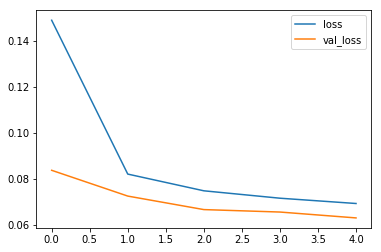

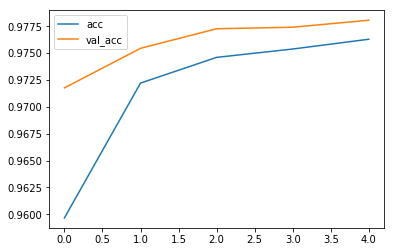

In [71]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [72]:
p = model.predict(test_data)

In [73]:
aucs = []
for j in range(6):
    auc = roc_auc_score(test_targets[:, j], p[:, j])
    aucs.append(auc)
    
print(np.mean(aucs))

0.95395783393
